In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#Installing dependencies
!pip install music21
!apt-get install -y lilypond

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lmodern fonts-noto-mono fonts-urw-base35 ghostscript
  libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libptexenc1
  libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lilypond-data
  lilypond-fonts lmodern poppler-data t1utils tex-common texlive-base texlive-binaries
  texlive-latex-base xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre ghostscript-x lilypond-doc
  python3-lxml poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic
  | fonts-ipafont-gothic fonts-arphic-ukai fonts-arphic-uming fonts-nanum debhelper perl-tk xpdf
  | pdf-viewer xzdec texlive-latex-base-doc
The following NEW packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lmodern

In [5]:
!pip install music21
!apt-get install -y lilypond

#Importing Libraries
import os
import tensorflow  as tf
import numpy as np
import pandas as pd
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lmodern fonts-noto-mono fonts-urw-base35 ghostscript
  libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libptexenc1
  libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lilypond-data
  lilypond-fonts lmodern poppler-data t1utils tex-common texlive-base texlive-binaries
  texlive-latex-base xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre ghostscript-x lilypond-doc
  python3-lxml poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic
  | fonts-ipafont-gothic fonts-arphic-ukai fonts-arphic-uming fonts-nanum debhelper perl-tk xpdf
  | pdf-viewer xzdec texlive-latex-base-doc
The following NEW packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lmodern

<a id="2"></a>
# <p style="background-color:#97BACB;font-family:newtimeroman;color:#EBDDD0;font-size:120%;text-align:center;border-radius:40px 40px;">LOADING DATA</p>

For this project, I will be using MIDI files of classical piano music. The dataset includes various artists. I will be working with Frédéric Chopin's compositions.

* First of all, I make a list of all the songs in the Chopin folder parsed as music21 stream.

* Then I will be creating a function to extract chords and notes out of the data creating a corpus.

**Laoding and parsing data**

In [8]:
#Loading the list of chopin's midi files as stream
filepath = "/content/sample_data/music/chopin/"
#Getting midi files
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath+i
        midi = converter.parse(tr)
        all_midis.append(midi)

Next, I get the components out of these streams of MIDI files. The midi files only have the piano included as mentioned in the dataset. So the components of the file would be either piano chords or piano notes.

**Note:** The musical notes are the building blocks of the music. It pertains to a pitch associated with a specific audio vibration. Western music utilizes twelve musical notes.

**Chord:** A group of notes that sound good together is a chord.

The music21 stream that was created in the above cell contains both, chords and notes, we will extract them in the form of notes and obtain a series of notes in the musical composition.

**The function to get the notes:**

In [9]:
def extract_notes_and_tempos(file):
    result = []
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()

            current_tempo = None
            for element in pick:
                if isinstance(element, tempo.MetronomeMark):
                    # Store only tempo entries with non-None text
                    current_tempo = {
                        'text': element.text,  # Keep as is, won't be added if None
                        'quarterBPM': element.number,
                    }

                if isinstance(element, note.Note) and current_tempo and current_tempo['text'] is not None:
                    note_entry = {
                        'notes': str(element.pitch),
                        'text': current_tempo['text'],
                        'quarterBPM': current_tempo['quarterBPM']
                    }
                    result.append(note_entry)

                elif isinstance(element, chord.Chord) and current_tempo and current_tempo['text'] is not None:
                    chord_entry = {
                        'notes': ".".join(str(n) for n in element.normalOrder),
                        'text': current_tempo['text'],
                        'quarterBPM': current_tempo['quarterBPM']
                    }
                    result.append(chord_entry)
    return result

#Getting the list of notes as Corpus
Corpus= extract_notes_and_tempos(all_midis)
# print("Total notes in all the Debussy midis in the dataset:", len(Corpus))
print(np.shape(Corpus), Corpus)
# print(tempos)

(23708,) [{'notes': '8.1', 'text': 'maestoso', 'quarterBPM': 90}, {'notes': 'C#4', 'text': 'maestoso', 'quarterBPM': 90}, {'notes': '9.1', 'text': 'maestoso', 'quarterBPM': 90}, {'notes': '9.11', 'text': 'moderate', 'quarterBPM': 91}, {'notes': 'F#3', 'text': 'moderate', 'quarterBPM': 91}, {'notes': 'F#2', 'text': 'moderate', 'quarterBPM': 92}, {'notes': 'F#4', 'text': 'moderate', 'quarterBPM': 92}, {'notes': 'D5', 'text': 'moderate', 'quarterBPM': 93}, {'notes': 'D4', 'text': 'moderate', 'quarterBPM': 93}, {'notes': '8.1', 'text': 'moderate', 'quarterBPM': 93.5}, {'notes': 'C#4', 'text': 'moderate', 'quarterBPM': 93.5}, {'notes': '9.1', 'text': 'moderate', 'quarterBPM': 93.5}, {'notes': '1.2', 'text': 'moderate', 'quarterBPM': 93.5}, {'notes': 'B3', 'text': 'moderate', 'quarterBPM': 93.5}, {'notes': 'C#3', 'text': 'moderate', 'quarterBPM': 92.5}, {'notes': 'B4', 'text': 'moderate', 'quarterBPM': 92.5}, {'notes': 'G#5', 'text': 'moderate', 'quarterBPM': 91.5}, {'notes': 'G#4', 'text': 

So we have our data in the form of a corpus. A list of strings, if you will. Each string indicates a musical note. Let us explore this data corpus.

<a id="3"></a>
# <p style="background-color:#97BACB;font-family:newtimeroman;color:#EBDDD0;font-size:120%;text-align:center;border-radius:40px 40px;">DATA EXPLORATION</p>

**In this section, I will be:**
* Exploring the data Corpus
* Examine all the notes in the Corpus
* Simplifying our Corpus to Built a working model

**Let us have a look at the first 50 values in our corpus**

In [10]:
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        # Adding the tempo
        tempoEvent = tempo.MetronomeMark(text=i['text'])
        tempoEvent.offset=offset
        Melody.append(tempoEvent)

        # Checking if the note is a chord, else it's a note
        note_or_chord = i['notes']
        if ("." in note_or_chord or note_or_chord.isdigit()):
            chord_notes = note_or_chord.split(".") #Seperating the notes in chord
            notes = []
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else:
            note_snip = note.Note(note_or_chord)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])
Melody_Snippet.write('midi', "Generated.mid")


'Generated.mid'

In [11]:
print("First fifty values in the Corpus:", [item['notes'] for item in Corpus[:10]])

First fifty values in the Corpus: ['8.1', 'C#4', '9.1', '9.11', 'F#3', 'F#2', 'F#4', 'D5', 'D4', '8.1']


**Examine all the notes in the Corpus**

In [12]:
#Creating a count dictionary
count_num = Counter([tuple(item['notes']) for item in Corpus])
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 337


In [13]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrenc for a note in Corpus: 70.35014836795253
Most frequent note in Corpus appeared: 839 times
Least frequent note in Corpus appeared: 1 time


Clearly, there are some very rare notes in the melody; some so rare that it was played only once in the whole data. This would create a lot of problems. (I did run into most of them while writing this piece)
To spare us the error reports, let us have a look at the frequency of the notes.
And for simplicity, I shall be eliminating some of the least occurring notes. I am sure Chopin wouldn't mind me messing with his masterpiece for science or would he? Either way, I may never know!   

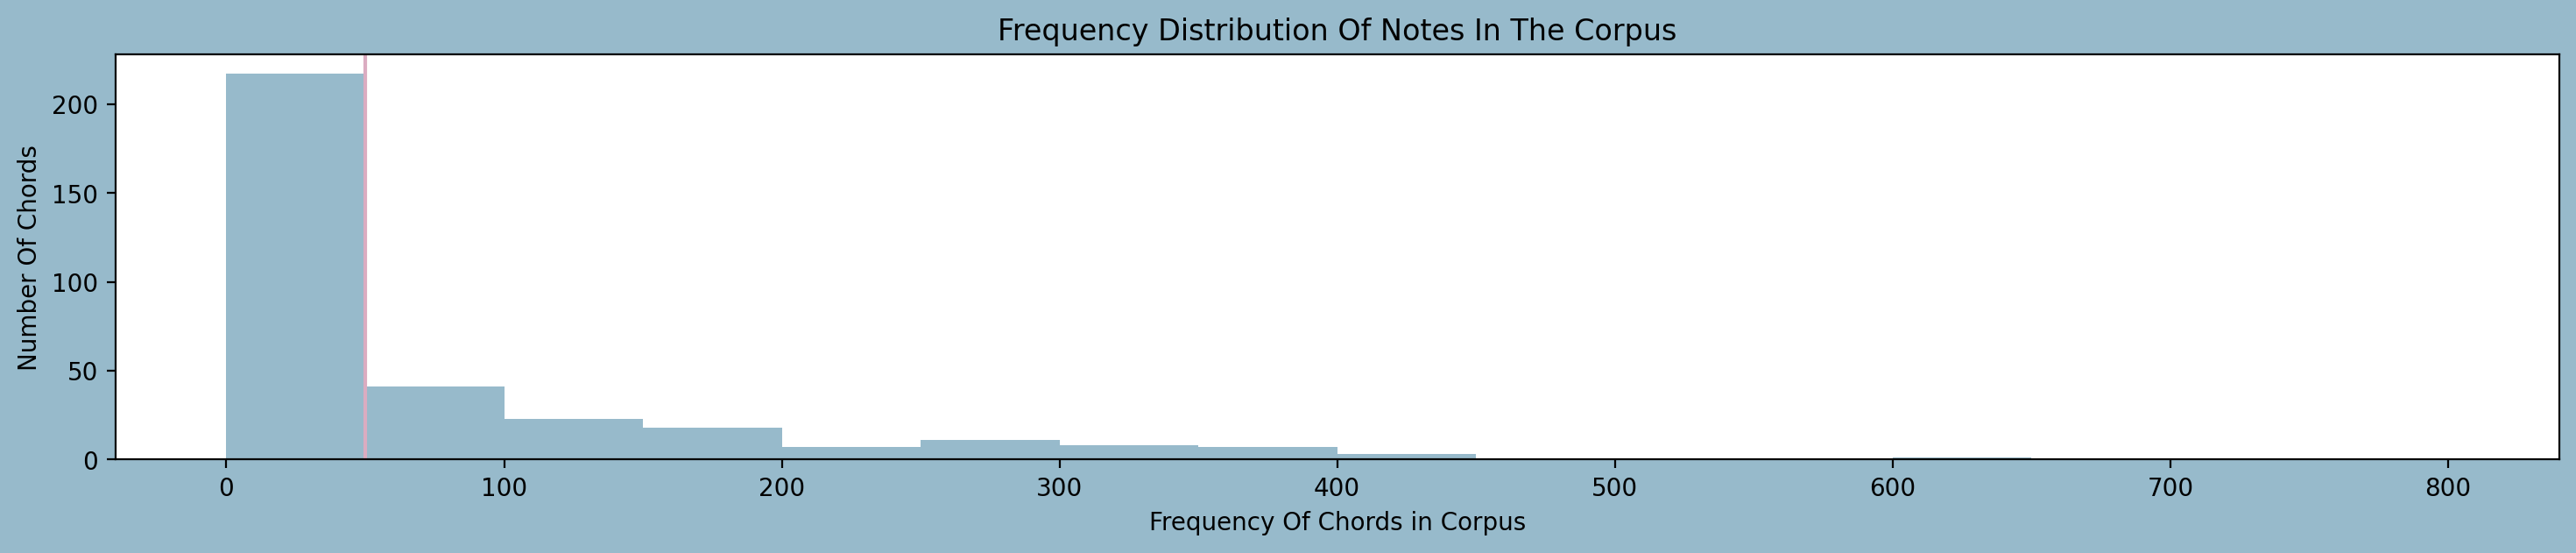

In [14]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50)
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=50,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

In [15]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 50:
        m =  ''.join(key)
        rare_note.append(m)

print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 217


In [16]:
#Eleminating the rare notes
for element in Corpus:
    if element['notes'] in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 21689


Finally! This is the cleaned data Corpus that I will be using for the music generation.  
In the next section, I will be preprocessing this Corpus for the training model.

The workflow for this project involves,

<p style="background-color:#EBDDD0;font-family:newtimeroman;color:#444160;text-align:center;font-size:120%;">Loading Data ➡️ Preprocessing ➡️ Building Mapping Dictionary ➡️ Building Model ➡️ Generating Music</p>

As I have loaded and explored the data,  I will proceed further by pre-processing the text.  


<a id="4"></a>
# <p style="background-color:#97BACB;font-family:newtimeroman;color:#EBDDD0;font-size:120%;text-align:center;border-radius:40px 40px;">DATA PREPROCESSING</p>

Notes are basically sound waves. In music, we have certain specific combinations of Frequency and Wavelength standardized as said notes. Our Corpus has the name of that note. As we parsed the data at the time of loading we took the help of the music21 library (by nice people at MIT); The library fetches Frequency, Wavelength, duration etc for the given notes.



**In this section, I will be performing the following:**

**Creating a dictionary:** Creating a dictionary to map the notes and their indices. We have the note's name as a string the Corpus. For the computer, these names are just a symbol. So we create a dictionary to map each unique note in our Corpus to a number. And vice versa to retrieve the values at the time of prediction. This will be used to encode and decode the information going in and getting out of the RNN.

**Encoding and Splitting the corpus:** Encoding and splitting the corpus into smaller sequences of equal length: At this point, the Corpus contain notes. We will encode this corpus and create small sequences of equal lengths of features and the corresponding y. Each feature and target will contain the mapped index in the dictionary of the unique characters they signify.

**Assigning X and y:** The labels are then resized and normalized. Whereas the targets are one-hot encoded. Ready to be sent to the RNN for the training, but before that let us built the RNN model.

**Splitting Train and Seed datasets** To create music we will need to send some input to the RNN. For that, we will set aside a part of the data as seeds. We could have trained it all but I am no musician to come up with an input seed value.

**Creating a list of sorted unique characters**

In [17]:
df = pd.DataFrame(Corpus)
df

,notes,text,quarterBPM
0,8.1,maestoso,90.0
1,C#4,maestoso,90.0
2,9.1,maestoso,90.0
3,F#3,moderate,91.0
4,F#2,moderate,92.0
...,...,...,...
21684,3.7,animato,120.0
21685,10.3,allegretto,107.0
21686,10.3,andante,70.5
21687,E-3,adagio,56.0


In [18]:
from sklearn.preprocessing import LabelEncoder

df = pd.DataFrame(Corpus)
df

# Initialize label encoders
text_encoder = LabelEncoder()
notes_encoder = LabelEncoder()



# Fit and transform the text and referent columns
df['text_encoded'] = text_encoder.fit_transform(df['text'])
df['notes'] = notes_encoder.fit_transform(df['notes'])
# Optional: Create reverse mappings if needed
text_mapping = dict(zip(text_encoder.classes_, text_encoder.transform(text_encoder.classes_)))
notes_mapping = dict(zip(notes_encoder.classes_, notes_encoder.transform(notes_encoder.classes_)))

print("Text mapping:", text_mapping)
print("Notes mapping:", notes_mapping)

df = df.drop(columns='text')
df


Text mapping: {'adagietto': 0, 'adagio': 1, 'allegretto': 2, 'allegrissimo': 3, 'allegro': 4, 'allegro moderato': 5, 'andante': 6, 'andante moderato': 7, 'andantino': 8, 'animato': 9, 'grave': 10, 'largamente': 11, 'larghetto': 12, 'largo': 13, 'lento': 14, 'maestoso': 15, 'moderate': 16, 'molto allegro': 17, 'prestissimo': 18, 'presto': 19, 'vivace': 20, 'vivacissimo': 21}
Notes mapping: {'0': 0, '0.1': 1, '0.2': 2, '0.2.5': 3, '0.2.6': 4, '0.3': 5, '0.3.5': 6, '0.3.6': 7, '0.3.7': 8, '0.4': 9, '0.4.6': 10, '0.4.7': 11, '0.5': 12, '0.6': 13, '1': 14, '1.2': 15, '1.2.3': 16, '1.3': 17, '1.3.7': 18, '1.3.8': 19, '1.4': 20, '1.4.6': 21, '1.4.7': 22, '1.4.7.10': 23, '1.4.7.9': 24, '1.5': 25, '1.5.6': 26, '1.5.8': 27, '1.6': 28, '1.7': 29, '10': 30, '10.0': 31, '10.0.3.6': 32, '10.1': 33, '10.1.4': 34, '10.1.5': 35, '10.11': 36, '10.2': 37, '10.2.5': 38, '10.3': 39, '11': 40, '11.0': 41, '11.0.4': 42, '11.1': 43, '11.1.5': 44, '11.2': 45, '11.2.5': 46, '11.2.6': 47, '11.3': 48, '11.4': 49,

,notes,quarterBPM,text_encoded
0,120,90.0,15
1,162,90.0,15
2,134,90.0,15
3,194,91.0,16
4,193,92.0,16
...,...,...,...
21684,71,120.0,9
21685,39,107.0,2
21686,39,70.5,6
21687,181,56.0,1


In [19]:
uniqueNotesCount = len(notes_mapping)
uniqueTextCount = len(text_mapping)
uniqueNotesCount, uniqueTextCount

(216, 22)

**Encoding and Splitting the Corpus as Labels and Targets**

In [20]:
#Splitting the Corpus in equal length of strings and output target
length = 40 #PLAY WITH THIS VALUE
CorpusCopy = df.to_numpy()
L_corpus = len(CorpusCopy)  # length of corpus
X = [] #The things which will be predicting from, e.g. last 20 data points
y = [] #The things we want to predict based on X


for i in range(0, L_corpus - length, 1):
    X.append(CorpusCopy[i:i+length])
    y.append(CorpusCopy[i+length])

L_datapoints = len(y)
print("Total number of sequences in the Corpus:", L_datapoints)
np.shape(X), np.shape(y)

Total number of sequences in the Corpus: 21649


((21649, 40, 3), (21649, 3))

**Splitting Train and Seed datasets**

In [23]:
#Taking out a subset of data to be used as seed

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val= train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)


In [24]:
X_train, y_train

([array([[ 73.  ,  84.82,   7.  ],
         [169.  ,  82.52,   7.  ],
         [208.  ,  80.79,   8.  ],
         [207.  ,  80.79,   8.  ],
         [116.  ,  80.79,   8.  ],
         [180.  ,  67.5 ,   0.  ],
         [  5.  ,  58.  ,   1.  ],
         [ 65.  ,  58.  ,   1.  ],
         [ 65.  ,  59.5 ,  12.  ],
         [ 65.  ,  60.5 ,  12.  ],
         [ 65.  ,  58.  ,   1.  ],
         [205.  ,  65.5 ,   0.  ],
         [206.  ,  67.  ,   0.  ],
         [168.  ,  65.  ,   0.  ],
         [208.  ,  60.5 ,  12.  ],
         [ 30.  , 141.57,   3.  ],
         [107.  , 130.57,   4.  ],
         [181.  , 182.  ,  19.  ],
         [104.  , 206.6 ,  18.  ],
         [182.  , 206.6 ,  18.  ],
         [144.  , 206.6 ,  18.  ],
         [109.  , 206.6 ,  18.  ],
         [213.  , 208.75,  18.  ],
         [ 27.  , 208.17,  18.  ],
         [201.  , 208.17,  18.  ],
         [ 30.  , 185.59,  19.  ],
         [107.  , 182.6 ,  19.  ],
         [196.  , 209.93,  18.  ],
         [183.  , 20

<a id="5"></a>
# <p style="background-color:#97BACB;font-family:newtimeroman;color:#EBDDD0;font-size:120%;text-align:center;border-radius:40px 40px;">MODEL BUILDING</p>

I will be employing an LSTM for this project.

**Following steps are involved in the model building**

* Initialising the Model
* Defining by adding layers
* Compiling the Model
* Training the Model

**Building the Model**

In [25]:
input_shape = (np.shape(X)[1], np.shape(X)[2])# (timesteps, features)
input_shape

(40, 3)

mew model with l2 and batch normalization

In [26]:
# Define input shape
input_shape = (np.shape(X)[1], np.shape(X)[2])  # (timesteps, features)

inputs = Input(shape=input_shape, name='input')

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

# LSTM with regularization and batch normalization
lstm1 = LSTM(512,
             return_sequences=True,
             recurrent_dropout=0.4,
             name='1stLSTM')(inputs)
batch_norm1 = BatchNormalization(name='1stBatchNorm')(lstm1)
dropout1 = Dropout(0.4, name='1stDropout')(batch_norm1)

lstm2 = LSTM(256,
             recurrent_dropout=0.3,
             name='2ndLSTM')(dropout1)
batch_norm2 = BatchNormalization(name='2ndBatchNorm')(lstm2)
dropout2 = Dropout(0.4, name='2ndDropout')(batch_norm2)

# Dense layer with regularization and batch normalization
dense_shared = Dense(256, name='Dense')(dropout2)
batch_norm_dense = BatchNormalization(name='DenseBatchNorm')(dense_shared)

# Output heads with softmax activation for categorical outputs
output_notes = Dense(uniqueNotesCount, activation='softmax', name='notes')(dense_shared)
output_text = Dense(uniqueTextCount, activation='softmax', name='text')(dense_shared)

# Create model with multiple outputs
model = Model(inputs=inputs, outputs=[output_notes, output_text])

# Compile model with sparse categorical crossentropy

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='loss',
    patience=10,
    restore_best_weights=True
)

# Learning rate reduction
reduce_lr = ReduceLROnPlateau(
    monitor='loss',
    factor=0.2,  # Reduce learning rate by 80%
    patience=5,
    min_lr=0.0001
)


opt = Adamax(learning_rate=0.01)
model.compile(
    optimizer=opt,
    loss={
        'notes': 'sparse_categorical_crossentropy',
        # 'numbers': 'MSE',
        'text': 'sparse_categorical_crossentropy'
    },
    loss_weights={
        'notes': 0.6,
        # 'numbers': 1.0,
        'text': 1.2
    }
)

In [27]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 40, 3)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 1stLSTM (LSTM)            │ (None, 40, 512)        │      1,056,768 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 1stBatchNorm              │ (None, 40, 512)        │          2,048 │ 1stLSTM[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 1stDropout (Dropout)      │ (None, 40, 512)        │              0 │ 1stBatchNorm[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 2ndLSTM (LSTM)            │ (None, 256)            │        787,456 │ 1stDropout[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 2ndBatchNorm              │ (None, 256)            │          1,024 │ 2ndLSTM[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ 2ndDropout (Dropout)      │ (None, 256)            │              0 │ 2ndBatchNorm[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dense (Dense)             │ (None, 256)            │         65,792 │ 2ndDropout[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ notes (Dense)             │ (None, 216)            │         55,512 │ Dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text (Dense)              │ (None, 22)             │          5,654 │ Dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,974,254 (7.53 MB)

 Trainable params: 1,972,718 (7.53 MB)

 Non-trainable params: 1,536 (6.00 KB)

removed validation

In [28]:
# Split y into separate target arrays for training set
y_notes_train = [x[0] for x in y_train]
y_numbers_train = [x[1] for x in y_train]
y_text_train = [x[2] for x in y_train]

# Stack the target arrays for the training set
y_notes_train = tf.stack(y_notes_train)
y_numbers_train = tf.stack(y_numbers_train)
y_text_train = tf.stack(y_text_train)

# Stack the input features for the training set
X_train = tf.stack(X_train)


without validation

In [29]:
# Train the model with validation data
history = model.fit(
    X_train,
    {
        'notes': y_notes_train,
        'text': y_text_train
    },
    epochs=200,
    batch_size=256,
    callbacks= [early_stopping, reduce_lr]
)

Epoch 1/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - loss: 6.3739 - notes_loss: 3.2918 - text_loss: 3.0814 - learning_rate: 0.0100
Epoch 2/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 4.2945 - notes_loss: 2.7432 - text_loss: 1.5513 - learning_rate: 0.0100
Epoch 3/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 3.9458 - notes_loss: 2.6013 - text_loss: 1.3446 - learning_rate: 0.0100
Epoch 4/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 3.7703 - notes_loss: 2.5293 - text_loss: 1.2410 - learning_rate: 0.0100
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 3.6580 - notes_loss: 2.4725 - text_loss: 1.1860 - learning_rate: 0.0100
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 3.6258 - notes_loss: 2.4442 - text_loss: 1.1815 - learning_rate: 0.0100
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 3.5140 - notes_loss: 2.4130 - text_loss: 1.1011 - learning_rate: 0.0100
Epoch 8/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 3.5407 - notes_

In [30]:
import matplotlib.pyplot as plt

# Extract losses from the history object
epochs = range(1, len(history.history['loss']) + 1)

# Overall loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Losses for individual outputs
notes_loss = history.history['notes_loss']
val_notes_loss = history.history['val_notes_loss']

# numbers_loss = history.history['numbers_loss']
# val_numbers_loss = history.history['val_numbers_loss']

text_loss = history.history['text_loss']
val_text_loss = history.history['val_text_loss']

# Plot overall loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Overall Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot individual losses
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(epochs, notes_loss, 'b-', label='Training Notes Loss')
plt.plot(epochs, val_notes_loss, 'r-', label='Validation Notes Loss')
plt.title('Notes Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# plt.subplot(3, 1, 2)
# plt.plot(epochs, numbers_loss, 'b-', label='Training Numbers Loss')
# plt.plot(epochs, val_numbers_loss, 'r-', label='Validation Numbers Loss')
# plt.title('Numbers Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid()

plt.subplot(3, 1, 3)
plt.plot(epochs, text_loss, 'b-', label='Training Text Loss')
plt.plot(epochs, val_text_loss, 'r-', label='Validation Text Loss')
plt.title('Text Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


KeyError: 'val_loss'

<a id="6"></a>
# <p style="background-color:#97BACB;font-family:newtimeroman;color:#EBDDD0;font-size:120%;text-align:center;border-radius:40px 40px;">EVALUATING MODELS</p>

Now that I have my model trained on the MIDI files of piano music, let us see how it performs.

**To evaluate my model, I shall be having a look at:**
* The performance of the model via Learning Curves
* The melody created

**Plotting the learning curve for the loss function**

[Text(0.5, 0, 'Epochs')]

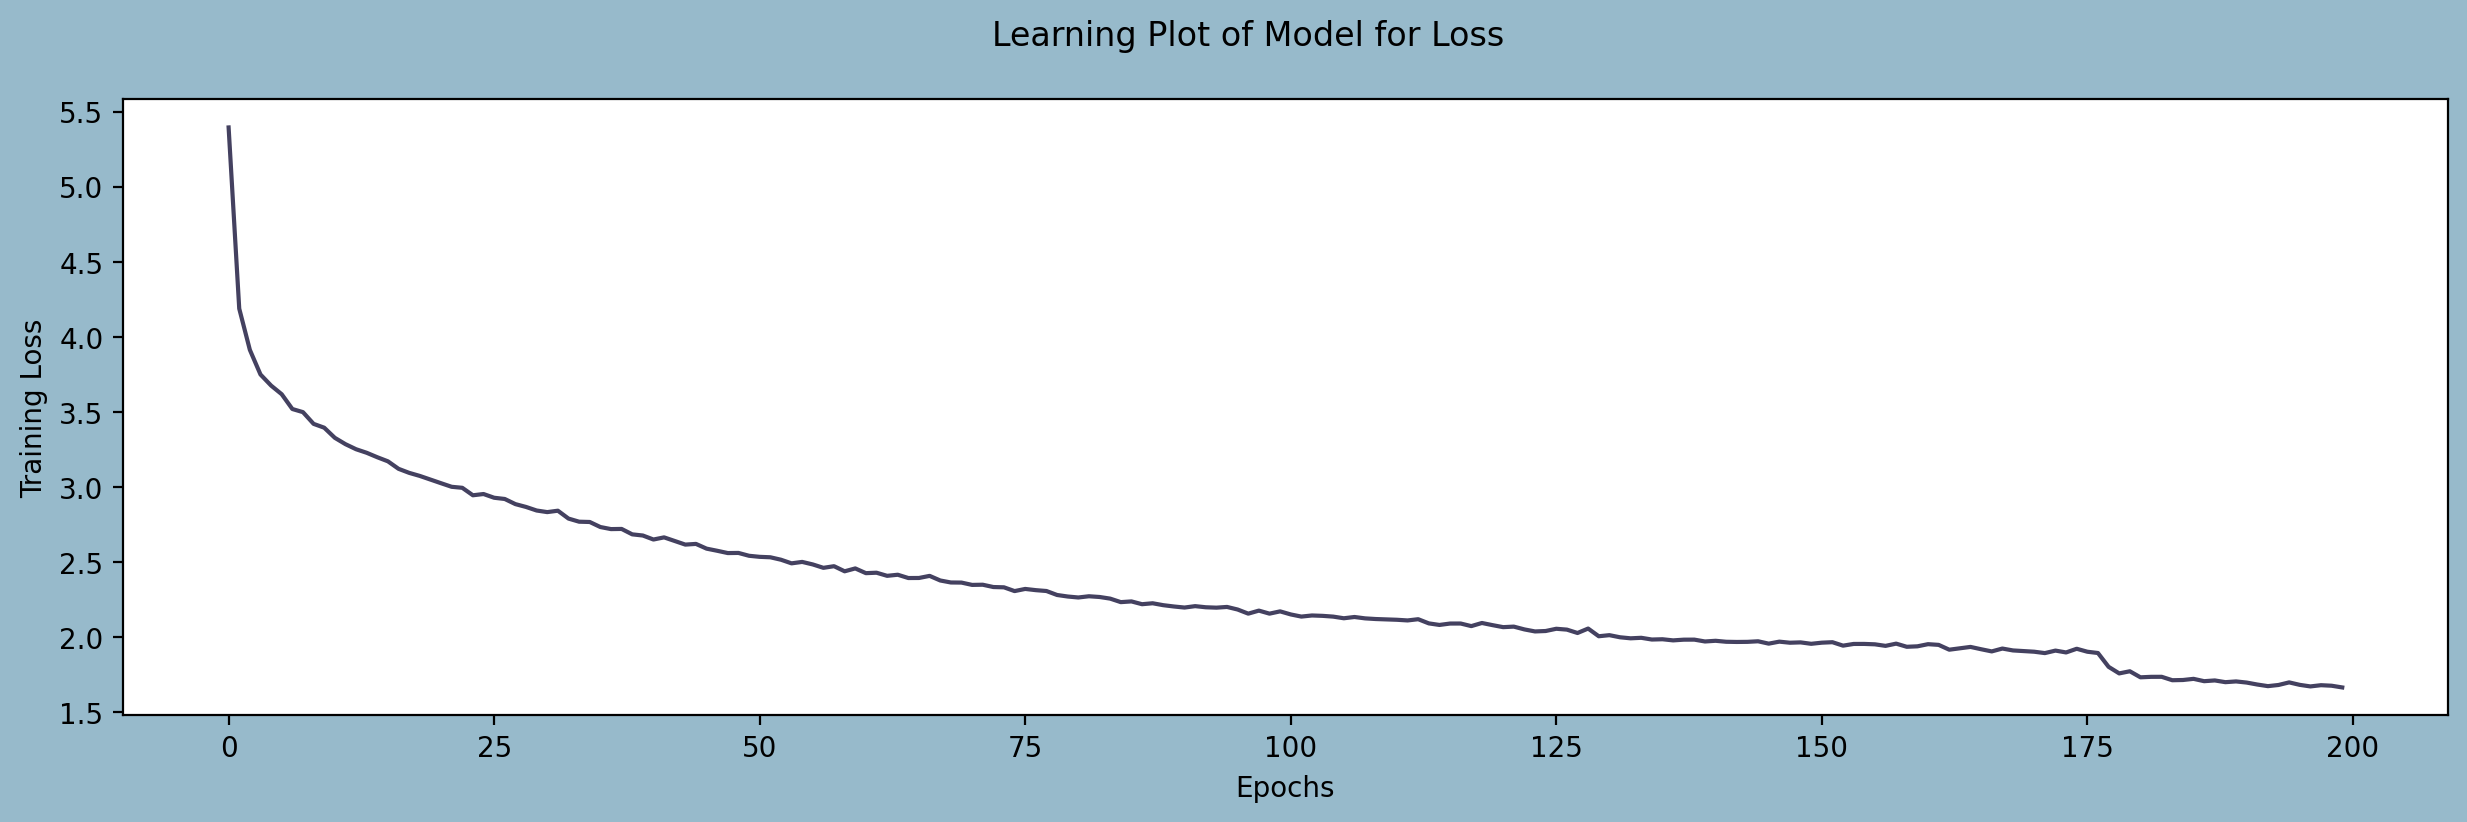

In [31]:
#Plotting the learnings
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

**Generating the Melody**

A function to obtain the generated music

In [32]:
sampleSeed = X_test[np.random.randint(0,len(X_test)-1)]
sampleSeed = sampleSeed.reshape(1, 40, 3)
samplePrediction = model.predict(sampleSeed, verbose=0)

In [33]:
index = np.argmax(samplePrediction[0][0]) # index of the most probable note
index, samplePrediction[0][0][index]

(48, 0.5479172)

In [34]:
notes_encoder.inverse_transform([index])[0]

'11.3'

In [35]:
indexText = np.argmax(samplePrediction[1][0])
indexText, samplePrediction[1][0][indexText]

(2, 0.99950194)

In [36]:
text_encoder.inverse_transform([indexText])

array(['allegretto'], dtype=object)

In [37]:
tempo.MetronomeMark(text='andante moderato').getQuarterBPM()

83.0

In [43]:
def generateMelody(Note_Count, temperature=15):
    # Get random sequence of given length (40) objects from the test set
    seed = X_test[np.random.randint(0,len(X_test)-1)]
    Music = []
    for i in range(Note_Count):
        # Reshaping the input to be (batch size, 40, 3)
        seed = seed.reshape(1,40,3)

        # Predicting and extracting notes and tempo text
        prediction = model.predict(seed, verbose=0)
        notesPredictions = prediction[0][0]
        tempoTextPredicitons = prediction[1][0]

        # Applying temperature -
        #   higher value (2.0) - more creative predictions
        #   lower value (0.5) - less creative, more precise
        notesPredictions = np.log(notesPredictions) / temperature
        exp_preds = np.exp(notesPredictions)
        notesPredictions = exp_preds / np.sum(exp_preds)

        tempoTextPredicitons = np.log(tempoTextPredicitons) / temperature
        exp_preds = np.exp(tempoTextPredicitons)
        tempoTextPredicitons = exp_preds / np.sum(exp_preds)

        # Getting the prediction with highest probability
        indexNote = np.argmax(notesPredictions)
        indexTempoText = np.argmax(tempoTextPredicitons)

        # Inverse the encoding process
        note = notes_encoder.inverse_transform([indexNote])[0]
        tempoText = text_encoder.inverse_transform([indexTempoText])[0]

        # Create one object and append it into Music array
        onePrediction = {'notes': note, 'text': tempoText}
        print(onePrediction)
        Music.append(onePrediction)

        # Move the 'window' for the next predictions
        # by removing the first object from the sequence
        # at index 0, where index 40 is the last index before making the prediction
        # After removal, append the object that was just predicted,
        # apply transformations to encode this object.
        newSample = np.array([
            notes_encoder.transform([note])[0],  # Transform the predicted note back to numeric
            tempo.MetronomeMark(text=tempoText).getQuarterBPM(),
            text_encoder.transform([tempoText])[0]  # Transform the predicted tempo text back to numeric
        ])
        print(newSample)
        seed = np.roll(seed, -1, axis=1)
        seed[0, -1, :] = newSample
        # print(newSample, seed)


    #The Music file contains objects {note, text} and we transform it into Midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)
    return Music,Melody_midi


#getting the Notes and Melody created by the model
Music_notes, Melody = generateMelody(40,0.8)


{'notes': 'C#3', 'text': 'moderate'}
[161.  92.  16.]
{'notes': 'C#3', 'text': 'moderate'}
[161.  92.  16.]
{'notes': 'C#3', 'text': 'moderate'}
[161.  92.  16.]
{'notes': 'C#3', 'text': 'moderate'}
[161.  92.  16.]
{'notes': 'C#3', 'text': 'moderate'}
[161.  92.  16.]
{'notes': 'C#3', 'text': 'moderate'}
[161.  92.  16.]
{'notes': 'C#4', 'text': 'moderate'}
[162.  92.  16.]
{'notes': 'C#4', 'text': 'moderate'}
[162.  92.  16.]
{'notes': 'C#4', 'text': 'moderate'}
[162.  92.  16.]
{'notes': 'C#4', 'text': 'moderate'}
[162.  92.  16.]
{'notes': 'C#4', 'text': 'moderate'}
[162.  92.  16.]
{'notes': 'C#4', 'text': 'moderate'}
[162.  92.  16.]
{'notes': 'C#4', 'text': 'moderate'}
[162.  92.  16.]
{'notes': 'G#2', 'text': 'moderate'}
[206.  92.  16.]
{'notes': 'C#4', 'text': 'moderate'}
[162.  92.  16.]
{'notes': 'C#4', 'text': 'moderate'}
[162.  92.  16.]
{'notes': 'G#3', 'text': 'moderate'}
[207.  92.  16.]
{'notes': 'C#4', 'text': 'moderate'}
[162.  92.  16.]
{'notes': 'G#2', 'text': 'mo

new generation

In [47]:
def generateMelody(Note_Count, temperature=1.0):
    # Get random sequence of given length (40) objects from the test set
    seed = X_test[np.random.randint(0, len(X_test) - 1)]
    Music = []

    for i in range(Note_Count):
        # Reshape the input to be (batch size, 40, 3)
        seed = seed.reshape(1, 40, 3)

        # Predict notes and tempo text
        prediction = model.predict(seed, verbose=0)
        notesPredictions = prediction[0][0]
        tempoTextPredicitons = prediction[1][0]

        # Apply temperature scaling
        notesPredictions = np.log(notesPredictions + 1e-7) / temperature
        notesPredictions = np.exp(notesPredictions) / np.sum(np.exp(notesPredictions))

        tempoTextPredicitons = np.log(tempoTextPredicitons + 1e-7) / temperature
        tempoTextPredicitons = np.exp(tempoTextPredicitons) / np.sum(np.exp(tempoTextPredicitons))

        # Sample predictions based on probability distributions
        indexNote = np.random.choice(len(notesPredictions), p=notesPredictions)
        indexTempoText = np.random.choice(len(tempoTextPredicitons), p=tempoTextPredicitons)

        # Inverse transform predictions to original values
        note = notes_encoder.inverse_transform([indexNote])[0]
        tempoText = text_encoder.inverse_transform([indexTempoText])[0]

        # Create one object and append it to Music array
        onePrediction = {'notes': note, 'text': tempoText}
        Music.append(onePrediction)

        # Update the seed sequence
        newSample = np.array([
            notes_encoder.transform([note])[0],
            tempo.MetronomeMark(text=tempoText).getQuarterBPM(),
            text_encoder.transform([tempoText])[0]
        ])
        seed = np.roll(seed, -1, axis=1)
        seed[0, -1, :] = newSample

    # Convert the Music array to MIDI
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)
    return Music, Melody_midi
#getting the Notes and Melody created by the model
Music_notes, Melody = generateMelody(40,0.5)

does not repeat sounds

In [ ]:
def generateMelody(Note_Count, temperature=50):
    # Get random sequence of given length (40) objects from the test set
    seed = X_test[np.random.randint(0, len(X_test) - 1)]
    Music = []
    recent_notes = []  # To track recent note predictions
    recent_tempos = []  # To track recent tempo predictions

    for i in range(Note_Count):
        # Reshape the input to be (batch size, 40, 3)
        seed = seed.reshape(1, 40, 3)

        # Predict notes and tempo text
        prediction = model.predict(seed, verbose=0)
        notesPredictions = prediction[0][0]
        tempoTextPredicitons = prediction[1][0]

        # Apply temperature scaling
        notesPredictions = np.log(notesPredictions + 1e-7) / temperature
        notesPredictions = np.exp(notesPredictions) / np.sum(np.exp(notesPredictions))

        tempoTextPredicitons = np.log(tempoTextPredicitons + 1e-7) / temperature
        tempoTextPredicitons = np.exp(tempoTextPredicitons) / np.sum(np.exp(tempoTextPredicitons))

        # Adjust probabilities to avoid repeating the last 3 predictions
        if len(recent_notes) >= 2:
            for note in recent_notes[-2:]:
                notesPredictions[note] = 0  # Set probability of repeated notes to 0
            # Re-normalize the probabilities
            notesPredictions = notesPredictions / np.sum(notesPredictions)

        if len(recent_tempos) >= 2:
            for tempo in recent_tempos[-2:]:
                tempoTextPredicitons[tempo] = 0  # Set probability of repeated tempos to 0
            # Re-normalize the probabilities
            tempoTextPredicitons = tempoTextPredicitons / np.sum(tempoTextPredicitons)

        # Sample predictions based on probability distributions
        indexNote = np.random.choice(len(notesPredictions), p=notesPredictions)
        indexTempoText = np.random.choice(len(tempoTextPredicitons), p=tempoTextPredicitons)

        # Inverse transform predictions to original values
        note = notes_encoder.inverse_transform([indexNote])[0]
        tempoText = text_encoder.inverse_transform([indexTempoText])[0]

        # Create one object and append it to Music array
        onePrediction = {'notes': note, 'text': tempoText}
        Music.append(onePrediction)

        # Update recent predictions
        recent_notes.append(indexNote)
        recent_tempos.append(indexTempoText)

        # Update the seed sequence
        newSample = np.array([
            notes_encoder.transform([note])[0],
            tempo.MetronomeMark(text=tempoText).getQuarterBPM(),
            text_encoder.transform([tempoText])[0]
        ])
        seed = np.roll(seed, -1, axis=1)
        seed[0, -1, :] = newSample

    # Convert the Music array to MIDI
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)
    return Music, Melody_midi
#getting the Notes and Melody created by the model
Music_notes, Melody = generateMelody(40,0.8)

v2

In [45]:
def generateMelody(Note_Count, temperature=1.5, penalty_factor=0.8):
    """
    Generate a melody with dynamic penalty for repeated notes.

    Args:
        Note_Count (int): Number of notes to generate.
        temperature (float): Controls randomness. Higher values increase diversity.
        penalty_factor (float): Reduces probability of recently used notes. Value < 1 applies penalty.

    Returns:
        tuple: Music notes (list) and MIDI stream.
    """
    # Get random sequence of given length (40) objects from the test set
    seed = X_test[np.random.randint(0, len(X_test) - 1)]
    Music = []
    recent_notes = []  # Store recently predicted notes
    recent_tempos = []  # Store recently predicted tempos
    max_recent = 3  # Number of recent predictions to penalize

    for i in range(Note_Count):
        # Reshape the input to be (batch size, 40, 3)
        seed = seed.reshape(1, 40, 3)

        # Predict notes and tempo text
        prediction = model.predict(seed, verbose=0)
        notesPredictions = prediction[0][0]
        tempoTextPredicitons = prediction[1][0]

        # Apply temperature scaling
        notesPredictions = np.log(notesPredictions + 1e-7) / temperature
        notesPredictions = np.exp(notesPredictions) / np.sum(np.exp(notesPredictions))

        tempoTextPredicitons = np.log(tempoTextPredicitons + 1e-7) / temperature
        tempoTextPredicitons = np.exp(tempoTextPredicitons) / np.sum(np.exp(tempoTextPredicitons))

        # Penalize recently used notes
        for recent_note in recent_notes[-max_recent:]:
            notesPredictions[recent_note] *= penalty_factor
        notesPredictions /= np.sum(notesPredictions)  # Re-normalize probabilities

        for recent_tempo in recent_tempos[-max_recent:]:
            tempoTextPredicitons[recent_tempo] *= penalty_factor
        tempoTextPredicitons /= np.sum(tempoTextPredicitons)  # Re-normalize probabilities

        # Sample predictions based on adjusted probabilities
        indexNote = np.random.choice(len(notesPredictions), p=notesPredictions)
        indexTempoText = np.random.choice(len(tempoTextPredicitons), p=tempoTextPredicitons)

        # Inverse transform predictions to original values
        note = notes_encoder.inverse_transform([indexNote])[0]
        tempoText = text_encoder.inverse_transform([indexTempoText])[0]

        # Create one object and append it to Music array
        onePrediction = {'notes': note, 'text': tempoText}
        Music.append(onePrediction)

        # Update recent predictions
        recent_notes.append(indexNote)
        recent_tempos.append(indexTempoText)

        # Update the seed sequence
        newSample = np.array([
            notes_encoder.transform([note])[0],
            tempo.MetronomeMark(text=tempoText).getQuarterBPM(),
            text_encoder.transform([tempoText])[0]
        ])
        seed = np.roll(seed, -1, axis=1)
        seed[0, -1, :] = newSample

    # Convert the Music array to MIDI
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)
    return Music, Melody_midi
#getting the Notes and Melody created by the model
Music_notes, Melody = generateMelody(40,0.6,0.3)

This sure looks like music! To check if it sounds like music we have to listen to the MIDI file. Playing midi is crumblesome. I have saved and converted a few generated melodies to ".wav" format outside of this notebook. So let us have a listen.

**Melody Generated Sample 1**

In [48]:
#To save the generated melody
Melody.write('midi','Melody_GeneratedN2v2T0.5.mid')
#to play audio or corpus
# IPython.display.Audio("../input/music-generated-lstm/Melody_Generated 2.wav")

'Melody_GeneratedN2v2T0.5.mid'

**Melody Generated Sample 2**

In [ ]:
#to play audio or corpus
IPython.display.Audio("../input/music-generated-lstm/Melody_Generated_1.wav")

ValueError: rate must be specified when data is a numpy array or list of audio samples.

<a id="7"></a>
# <p style="background-color:#97BACB;font-family:newtimeroman;color:#EBDDD0;font-size:120%;text-align:center;border-radius:40px 40px;">CONCLUSION</p>
<p style="font-family:newtimeroman;font-size:120%;color:#97BACB">On inspecting the generated melody, I am quite satisfied. Unlike the lyrics project, The music doesn't have to hold true to the grammatical syntax. On the question, is it a good musical composition; is it artsy? Did our LSTM create a masterpiece? I don't know! I am not a connoisseur of music. I used a basic RNN and it worked alright.</p>

<img src="https://github.com/KarnikaKapoor/Files/blob/main/music2.gif?raw=true">     
     
     
<p style="font-family:newtimeroman;font-size:120%;color:#97BACB">So I decided to let the model have the fame it deserved. I am releasing the album! It is out on my blog. Don't forget to get your copy!</p>

**Album** [Down The Uncanny Valley: Album Release](https://karnikakapoor.blogspot.com/2021/10/down-uncanny-valley.html)

**Some Useful Resources:**

[The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

[MuseNet](https://openai.com/blog/musenet/)

[Lyrics Generator](https://www.kaggle.com/karnikakapoor/lyrics-generator-rnn)


**<span style="color:#DBACC1;"> If you liked this Notebook, please do upvote.</span>**

**<span style="color:#DBACC1;"> If you have any questions, feel free to comment!</span>**

**<span style="color:#DBACC1;"> Best Wishes!</span>**

<a id="8"></a>
# <p style="background-color:#97BACB;font-family:newtimeroman;color:#EBDDD0;font-size:120%;text-align:center;border-radius:40px 40px;">END</p>